### package import
---
필요한 패키지를 모두 import했습니다.

In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# GitHub의 어텐션 함수 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

from summa.summarizer import summarize

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 데이터 가져오기
---
데이터셋을 받아 온 뒤, 데이터의 형태를 확인했습니다.\
text의 요약을 headlines로 판단하여 진행하도록 했습니다.

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
61415,Former CIA head slams Trump for attacking ex-i...,Former CIA chief John Brennan slammed US Presi...
96186,Another African national attacked in Greater N...,"According to reports, a female African student..."
73725,"Single ticket wins Ã¢ÂÂ¹4,860 crore lottery j...",A single ticket won the nearly $759 million (Ã...
31452,Shahid Kapoor confirms he will star in 'Arjun ...,Shahid Kapoor has confirmed he is starring in ...
15439,"Venezuela 'a mess', needs to be 'cleaned up': ...",Amid continued criticism of the Venezuelan gov...
46572,Antimatter to be transported out of a lab for ...,"In a first, antimatter made at the world's lar..."
42849,Good to let govt banks be free and owned by pu...,Infosys Chairman Nandan Nilekani has said it's...
40644,Maharashtra state board introduces new syllabu...,The Maharashtra state education board introduc...
93077,CBI files FIR against TMC leaders in Narada st...,The Central Bureau of Investigation on Monday ...
65453,Space radiation not a hurdle for a manned Mars...,As NASA is developing shielding material for s...


### 데이터 전처리1
---
중복을 배제한 수를 확인하고, 비어있는 값을 확인하여 headline과 text의 수를 같도록 만들었습니다.

In [4]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headline 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headline 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
data.drop_duplicates(subset = ['headlines'], inplace = True)
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98262


In [6]:
# 데이터프레임에 Null값이 있는지 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 텍스트 정규화 와 불용어 제거
---
같은 의미의 단어를 통일시켜 연산량을 줄이고 불용어를 처리하여 성능을 높였습니다.

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [8]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [9]:
clean_text = []

# 전체 text 데이터에 대한 전처리 
for s in data['text']:
    clean_text.append(preprocess_sentence(s, False))

# 전처리 후 출력
clean_text[:5]

['saurav kant an alumnus of upgrad and iiit pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad degree career support helped him transition to data scientist at tech mahindra with salary hike upgrad online power learning has powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult fit and more',
 'new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five match odi series india lost an international match under rohit sharma captaincy after consecutive victories dating back to march the match witnessed india getting all out for their seventh lowest total

In [10]:
clean_summary = []

# 전체 headline 데이터에 대한 전처리  
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s))

clean_summary[:5]

['upgrad learner switches career ml al salary hike',
 'delhi techie wins free food swiggy one year cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'known hirani yrs metoo claims true sonam']

### 데이터 재확인
---
정제과정에서 사라진 데이터를 null로 치환하여 사라진 데이터를 확인했습니다.

In [11]:
# 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있으므로 빈 값을 Null로 변환
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

data.isnull().sum()

headlines    0
text         0
dtype: int64

### 데이터 전처리 2
---
샘플의 최대길이를 결정하기 위해 길이와 분포를 출력 및 시각화했습니다.

헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 13
헤드라인의 평균 길이 : 7.136787364393153
텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 69
텍스트의 평균 길이 : 56.18195233152185


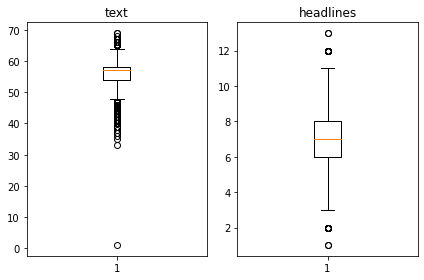

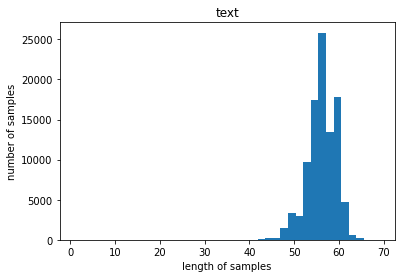

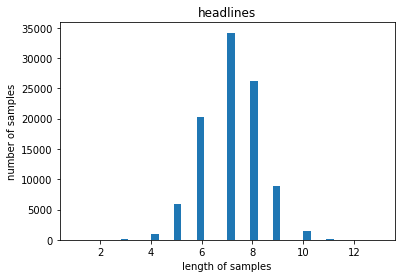

In [12]:
# 길이 분포 출력
import matplotlib.pyplot as plt

headlines_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]

print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 최대길이 결정
---
분포를 참조하여 최대길이를 임의로 결정하고 그에 해당하는 샘플비율을 확인한 뒤, 기준에 맞게 샘플을 정리했습니다.

In [13]:
# 최대길이 임의 설정
headlines_max_len = 11
text_max_len = 60

In [14]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [15]:
below_threshold_len(headlines_max_len, data['headlines'])
below_threshold_len(text_max_len,  data['text'])

전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.999745578148216
전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.9443528525778022


In [16]:
# 정해진 길이보다 길면 제외
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 92772


### 시작 토큰과 종료 토큰을 추가
---
요약 데이터의 시작 토큰과 종료 토큰을 추가했습니다.\
그리고 이를 numpy 타입으로 저장했습니다.

In [17]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant an alumnus of upgrad and iiit pg p...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
2,new zealand end rohit sharma led india match w...,new zealand defeated india by wickets in the f...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking about the sexual harassment allegatio...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken


In [18]:
encoder_input = np.array(data['headlines']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련 자료와 시험 자료 나누기
---
indice를 이용하여 순서를 섞은 뒤, 이를 8:2로 나눴습니다.

In [19]:
# 랜덤 정수 시퀀스를 이용하여 나눔
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[25989 64544 68982 ... 15379 15499 59522]


In [20]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)


테스트 데이터의 수 : 18554


In [21]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 74218
훈련 레이블의 개수 : 74218
테스트 데이터의 개수 : 18554
테스트 레이블의 개수 : 18554


### 데이터 전처리 3
---
keras를 이용하여 단어사전을 만들고 이를 토큰화하는 작업을 했습니다.\
등장빈도가 5회 미만인 단어는 학습에서 제외했습니다.

In [22]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

threshold = 5 # 등장 빈도수
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29400
등장 빈도가 4번 이하인 희귀 단어의 수: 18276
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11124
단어 집합에서 희귀 단어의 비율: 62.16326530612245
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.922040114179852


In [23]:
src_vocab = 11000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 11,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])
print(encoder_input_test[:3])

[[19, 8, 71, 94, 60, 45], [1, 883, 232, 4542, 47, 3840, 191, 213], [12, 1770, 9103, 1230, 370, 16, 13]]
[[431, 797, 10174, 1396, 116, 72], [28, 1936, 715, 561, 2154, 2568], [164, 359, 700, 1947, 4028, 3695]]


In [24]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29401
등장 빈도가 4번 이하인 희귀 단어의 수: 18276
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11125
단어 집합에서 희귀 단어의 비율: 62.16115098125914
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.193399291786581


In [25]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 21, 10, 73, 96, 62, 47], [1, 3, 885, 234, 4544, 49, 3842, 193, 215], [1, 14, 1772, 9105, 1232, 372, 18, 15], [1, 291, 745, 1686, 4880, 3047, 2907], [1, 37, 18, 239, 5080, 181, 227, 18]]
target
decoder  [[21, 10, 73, 96, 62, 47, 2], [3, 885, 234, 4544, 49, 3842, 193, 215, 2], [14, 1772, 9105, 1232, 372, 18, 15, 2], [291, 745, 1686, 4880, 3047, 2907, 2], [37, 18, 239, 5080, 181, 227, 18, 2]]


In [26]:
# 빈도수가 낮은 단어들로만 구성되었던 문장들을 제거
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 2
훈련 데이터의 개수 : 74217
훈련 레이블의 개수 : 74217
테스트 데이터의 개수 : 18552
테스트 레이블의 개수 : 18552


### 패딩 추가
---
모델에 이용하기위해 패딩을 추가하여 길이를 텐서의 형태를 맞춰줬습니다.

In [27]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

### 모델 설계
---
4개의 층과 128개의 임베딩 벡터, 256개의 hidden state로 구성되는 인코더를 만들었습니다.\
디코더에는 단어를 선택하기 위해 dense에 tav_vocab을 이용하고 활성화 함수로 softmax를 이용했습니다.\
또한 성능향상을 위해 어텐션 메커니즘을 이용했습니다.

In [28]:


# 인코더 설계 시작
embedding_dim = 128 # 임베딩벡터의 차원 수
hidden_size = 256 # LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터로 층 1개의 용량의 크기를 나타냄

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 4개로 구성하여 모델의 용량을 늘림
# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output3, state_h3, state_c3= encoder_lstm3(encoder_output2)

# 인코더의 LSTM 4
encoder_lstm4 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm4(encoder_output3)


# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1408000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 60, 256), (N 525312      lstm[0][0]                       
______________________________________________________________________________________________

### 어텐션 메커니즘
---
노드와 마찬가지로 깃헙의 어텐션 메커니즘을 이용하여 모델의 출력층을 수정했습니다.

In [29]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1408000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 60, 256), (N 525312      lstm[0][0]                       
____________________________________________________________________________________________

### 모델 훈련
---
node와 같이 earlystopping을 적용해서 조기종료가 이루어지도록 하고 학습을 진행했습니다.

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
290/290 [==============================] - 361s 1s/step - loss: 5.5853 - val_loss: 4.8746
Epoch 2/50
290/290 [==============================] - 344s 1s/step - loss: 4.8654 - val_loss: 4.5516
Epoch 3/50
290/290 [==============================] - 344s 1s/step - loss: 4.5352 - val_loss: 4.1786
Epoch 4/50
290/290 [==============================] - 345s 1s/step - loss: 4.1579 - val_loss: 3.7789
Epoch 5/50
290/290 [==============================] - 345s 1s/step - loss: 3.7759 - val_loss: 3.4505
Epoch 6/50
290/290 [==============================] - 344s 1s/step - loss: 3.3915 - val_loss: 2.8698
Epoch 7/50
290/290 [==============================] - 345s 1s/step - loss: 2.9358 - val_loss: 2.3701
Epoch 8/50
290/290 [==============================] - 346s 1s/step - loss: 2.5152 - val_loss: 2.0177
Epoch 9/50
290/290 [==============================] - 344s 1s/step - loss: 2.1891 - val_loss: 1.7032
Epoch 10/50
290/290 [==============================] - 344s 1s/step - loss: 1.9103 - val_lo

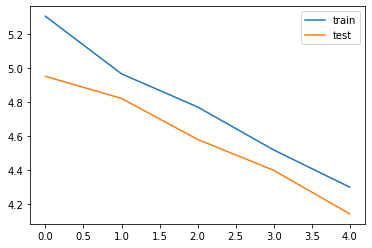

In [225]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델
---
정수 인덱스를 다시 실제 데이터로 복원하기 위한 사전을 형성하고,\
인퍼런스를 위한 별도의 모델을 설계했습니다.\
정답이 없고 문장을 만들어야 하기 때문입니다.

In [226]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [227]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (text_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

### 모델 확인
---
테스트 데이터에서 약 20개정도만 headline과 예측된 요약을 비교했습니다.\
여기서 현재까지 진행한 '추상적 요약'방식외에 '추출적 요약 방식도 추가하여 비교 할 계획이었지만,\
추출적 요약 방식을 위한 summa가 어떠한 단어도 출력하지 않기에 추상적 요약만 진행했습니다.

In [235]:
for i in range(50, 70):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
#     print("추출 요약 :", summarize(data['text'][i], words=headlines_max_len))

    print("\n")

원문 : clinton us would war oscar winning actress 
실제 요약 : clinton us would war oscar winning actress 
예측 요약 :  ex man gets wife wife goes viral


원문 : release date hrithik roshan super postponed 
실제 요약 : release date hrithik roshan super postponed 
예측 요약 :  trailer star alia kapoor


원문 : ready court settlement babri case 
실제 요약 : ready court settlement babri case 
예측 요약 :  sc asks plea plea


원문 : se race ka cast ho gaya salman anil 
실제 요약 : se race ka cast ho gaya salman anil 
예측 요약 :  cannot star kangana starrer remake


원문 : beauty stick face new trend 
실제 요약 : beauty stick face new trend 
예측 요약 :  people get new time


원문 : eu proposes turnover tax big tech companies 
실제 요약 : eu proposes turnover tax big tech companies 
예측 요약 :  uber bank may pay mn data


원문 : us congress votes scrap protection internet privacy 
실제 요약 : us congress votes scrap protection internet privacy 
예측 요약 :  pm modi asks people sexual harassment


원문 : girl lost pellet injuries clears class 
실제 요약 : girl los

### summa 를 활용하기 위한 시도
---
노드에서 제공된 text를 이용하여 요약한 결과 매우 잘 작동하는 것을 확인했습니다.\
뉴스기사 데이터를 이용한 경우에는 아무 것도 출력이 되지 않는데,\
이는 영어 문장 구조의 형식을 데이터가 지켜주지 않기 때문이라고 생각했습니다.\
따라서 문장의 첫 문자를 대문자로 전환하고 마지막에 마침표를 추가하는 시도를 해보았습니다만,\
여전히 같은 결과를 얻을 수 있을 뿐이었습니다.


In [237]:
import requests
from summa.summarizer import summarize

text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

print(text[:1500])
print(type(text))

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [236]:
print('Summary:')
print(summarize(text, words=headlines_max_len))

Summary:
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [230]:
from summa.summarizer import summarize

# textf = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1', dtype={'headlines':'str', 'text':'str'})
# textf = textf[['headlines','text']]
# textf = pd.DataFrame(data)
textc = data['text'][15]
# print(textf[:100])
print(textc[:50])
print('Summary:')

print(summarize(textc, ratio=0.005))

print(summarize(clean_text[9], words = 11), len(textc))
#print(summarize(data2['headlines']))
# print(summarize(clean_text[0], words=10))

KeyError: 15

In [152]:
type(clean_text[0])

str

In [127]:
clean_text[0]

'saurav kant an alumnus of upgrad and iiit pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad degree career support helped him transition to data scientist at tech mahindra with salary hike upgrad online power learning has powered lakh careers'

In [129]:
clean_summary[0]

'upgrad learner switches career ml al salary hike'

In [250]:

text3=data['text'][0] + '.'
text3=text3.capitalize()
print(type(text3))
print(text3)
print("추출 요약 :", summarize(text3, words=headlines_max_len))
print("추출 요약 :", summarize(text3, language='english'))
print("추출 요약 :", summarize(text3))

<class 'str'>
Saurav kant an alumnus of upgrad and iiit pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad degree career support helped him transition to data scientist at tech mahindra with salary hike upgrad online power learning has powered lakh careers.
추출 요약 : 
추출 요약 : 
추출 요약 : 


### 회고
---
추출적 요약 결과를 얻을 수 없어서 제대로 완수하지 못 한 노드가 된 것 같습니다.\
완성여부와 별개로 갖게 된 의문 중에 하나는, 예측을 위해 별도의 모델을 형성하는데,\
이 경우 데이터의 훈련이 예측에 어떤 도움을 줄 수 있는지 모르겠습니다.\
특히 코드상으로 model이 예측과정에서 전혀 쓰이지 않는 것을 확인했습니다.\
훈련된 모델을 별도로 둔다면, 훈련과정 역시 무의미한 것이 아니었을까요?
